# Data validity checks and cleaning

## Load the data and merge it with the item, category and shop tables

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [3]:
# Load from hdf5 format (separate files for simplicity)
item_categories = pd.read_hdf("data/item_categories.h5")
items = pd.read_hdf("data/items.h5")
train = pd.read_hdf("data/sales_train.h5")
shops = pd.read_hdf("data/shops.h5")
test = pd.read_hdf("data/test.h5")

Convert the date field to the datetime datatype to enable extra features

In [4]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

Merge the item_categories and items tables into the training and test data to gain additional information

In [5]:
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
test = test.merge(items, on="item_id", how="left")
test = test.merge(item_categories, on="item_category_id", how="left")

Let's have a quick look at the train data

In [65]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.000000,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.000000,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.050049,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.000000,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


Check for duplicated rows

In [48]:
print(f"There are {train.duplicated().sum()} duplicated rows")

There are 6 duplicated rows


No big deal, but we can remove them anyway.

In [7]:
train = train.drop_duplicates()

In [8]:
cols_with_na = [col for col in train if train[col].isna().sum()>0]
print(f"Following columns have missing values: {cols_with_na}")

Following columns have missing values: []


No missing values, good!

## Distribution of the target features

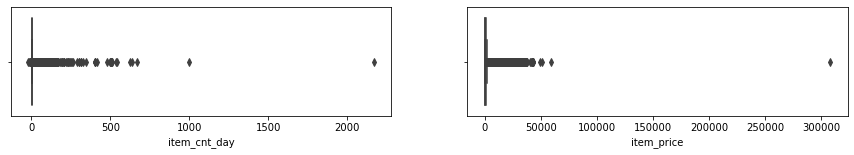

In [51]:
fig, axes = plt.subplots(1,2, figsize = (15,2))
_ = sns.boxplot(x=train.item_cnt_day, ax=axes[0])
_ = sns.boxplot(x=train.item_price, ax=axes[1])

In [57]:
print(f'99.99th quantile of "item_cnt_day" is {train.item_cnt_day.quantile(0.9999)}')
print(f'99.99th quantile of "item_price" is {train.item_price.quantile(0.9999)}')

99.99th quantile of "item_cnt_day" is 67.0
99.99th quantile of "item_price" is 29990.0


There appear to be a few outliers which might distort the model.  
These could be manually examined and cleaned to optimize the training data, or just be clipped or removed to save time. 

Check for negative item prices

In [53]:
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
484683,2013-05-15,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3


Just the one, it should be ok to remove it

Clean the data

In [9]:
# Remove outliers and 1 item with a negative sales price
train = train[(train.item_price < train.item_price.quantile(0.99999)) & (train.item_price > 0)]
train = train[train.item_cnt_day < train.item_cnt_day.quantile(0.99999)]
# Clip remaining lesser outliers
train['item_cnt_day'] = train['item_cnt_day'].clip(upper=20)
train['item_price'] = train['item_price'].clip(upper=30000)

# Test dataset

In [66]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


The train and test data as provided are mismatched, as the train data consists of per-day entries, while the test items are aggregated to the month level.  

A little exploration finds that each of the shop_ids is paired with the exact same set of item_ids. This suggests that the entries are the Cartesian product (i.e. all possible combinations) of a set of shops and items, which can be validated by checking the value counts of the shop_id and item_id's.

In [62]:
test['shop_id'].value_counts().value_counts()

5100    42
Name: shop_id, dtype: int64

In [63]:
test['item_id'].value_counts().value_counts()

42    5100
Name: item_id, dtype: int64

So there are 42 shop_ids and 5100 item_ids, 42 x 5100 = 214,200, the number of rows in the test table.

A reasonable assumption would be that the shops and items in the test set are those items for which there were at least one sale in the test month. A quick check of the validity of this is the compare the number of unique items in the test month with the unique items in each month of the train set.

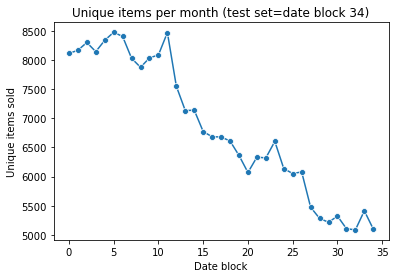

In [64]:
unique_items_date_block = [train.loc[train.date_block_num==x,:].item_id.unique().size for x in range(34)]
unique_items_date_block.append(test.item_id.unique().size)
ax = sns.lineplot(x = range(len(unique_items_date_block)), y = unique_items_date_block, marker='.', markersize=12)
_ = ax.set(xlabel = "Date block", ylabel = "Unique items sold", title = "Unique items per month (test set=date block 34)")

The number of unique test item_id's is close to those in preceding months. A trend of decreasing numbers of unique items in each month is clear. If this trend of decreasing unique items is related to sales trends in general, this implies a kind of data leak in the test table

It might be interesting to check how many of the items sold in previous months correspond to the items in the test data. We can check the intersection of the sets of these items.

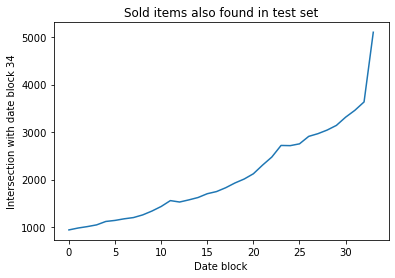

In [68]:
intersection = [len(set(train.loc[train.date_block_num==x,:].item_id).intersection(set(test.item_id))) for x in range(33)]
intersection.append(len(set(test.item_id)))
ax = sns.lineplot(x = range(len(intersection)), y = intersection)
_ = ax.set(xlabel = "Date block", ylabel = "Intersection with date block 34")
_ = ax.set_title("Sold items also found in test set")

This plot shows that the items sold in each month become more similar to those in the test set the closer the month is in time (as would be expected), but also that there are quite a lot of items in the test set which did not appear in the preceding month.  

We can check if this is some kind of anomaly by calculating how many new items normally appear each month.

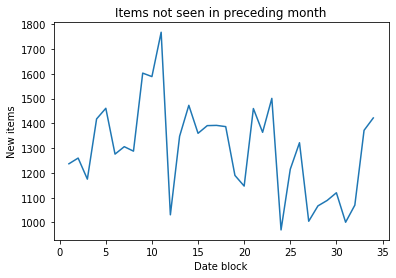

In [55]:
intersection = [len(set(sales_train.loc[sales_train.date_block_num==i+1,:].item_id) - 
    set(sales_train.loc[sales_train.date_block_num==i,:].item_id)) for i in range(33)]
intersection.append(len(set(sales_train.loc[sales_train.date_block_num==33].item_id) - set(test.item_id)))
ax = sns.lineplot(x = range(1, len(intersection)+1), y = intersection)
_ = ax.set(xlabel = "Date block", ylabel = "New items")
_ = ax.set_title("Items not seen in preceding month")

So the test set is entirely average in this respect. 
The hypothesis that the set of item_id's in the test set is those that recorded a sale seems sound.

# Exploring the training data

The following function reformats the training data to the same format as the test table, i.e. the Cartesian product of all items and shops that with a sale in each date block

In [7]:
def create_testlike_train(sales_train, test=None):
    # Create a date_block_num / item_id / shop_id index using all combinations of item_id and shop_id occurring within each date_block
    # Optionally concatenate the test items to the end
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = (
        sales_train["item_price"] * sales_train["item_cnt_day"]
    )

    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(
        ["date_block_num", "shop_id", "item_id"]
    ).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(
            column="item_revenue_day", aggfunc="sum"
        ),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped,
        how="left",
        on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

matrix = create_testlike_train(train)

## Sales per month
We can plot total item sale counts per month

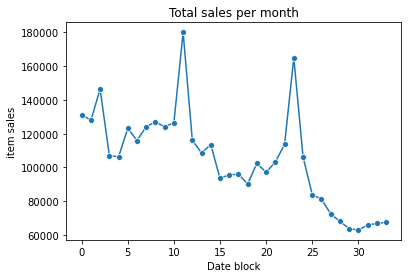

In [75]:
sales_by_month = matrix.groupby('date_block_num').item_cnt_month.sum()
ax = sns.lineplot(data=sales_by_month, marker='.', markersize=12)
_ = ax.set(xlabel = "Date block", ylabel = "item sales", title = "Total sales per month")

This shows a clear downwards and seasonal trend.  
However, the challenge is to predict the sales per item-shop combination in each month, which can be shown by plotting the mean per item in the reformed training set.

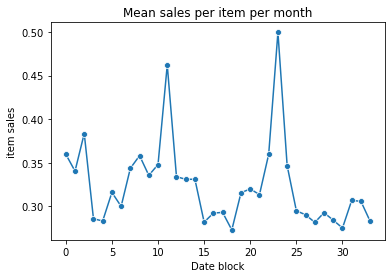

In [77]:
sales_by_month = matrix.groupby('date_block_num').item_cnt_month.mean()
ax = sns.lineplot(data=sales_by_month, marker='.', markersize=12)
_ = ax.set(xlabel = "Date block", ylabel = "item sales", title = "Mean sales per item per month")

The overall downwards trend is less clear here.

This can also be decomposed into seasonal and continuous trends, which shows the clear seasonal (i.e. year-end peak) trend and a mild overall downwards trend.

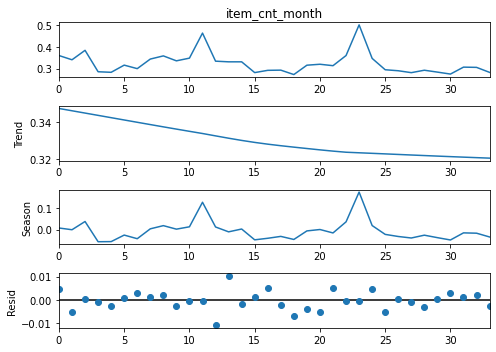

In [82]:
from statsmodels.tsa.seasonal import STL
result = STL(sales_by_month, period=12).fit()
fig = result.plot()
fig.set_size_inches((7,5))
fig.tight_layout()

## Sales as a function of item age

In [9]:
def item_shop_age_months(matrix):
    matrix["item_age"] = matrix.groupby("item_id")["date_block_num"].transform(
    lambda x: x - x.min()
    )
    matrix["new_item"] = matrix["item_age"] == 0
    matrix["new_item"] = matrix["new_item"].astype("int8")
    matrix["shop_age"] = (
        matrix.groupby("shop_id")["date_block_num"]
        .transform(lambda x: x - x.min())
        .astype("int8")
    )
    matrix["new_shop"] = matrix.shop_age == 0
    matrix["new_shop"] = matrix["new_shop"].astype("int8")
    return matrix

matrix = item_shop_age_months(matrix)

Plotting items as a function of their age indicates that they tend to sell most when they are new and then decline to a plateau about 1 year later. Item age is calculated here as the number of months since the month of their first appearence in the data. The slightly lower sales in the first compared to the second month is attributable to items not always being available for the whole month during their first calendar month of availability.

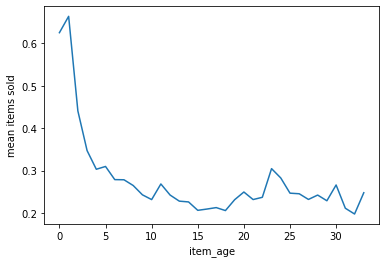

In [12]:
ax = matrix.groupby('item_age').item_cnt_month.mean().plot(ylabel='mean items sold')

The corresponding plot of sales according to shop age shows no such trend

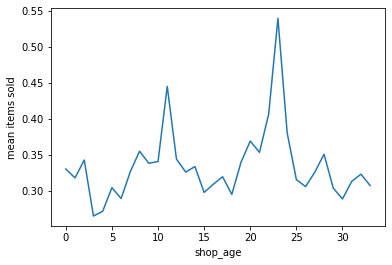

In [13]:
ax = matrix.groupby('shop_age').item_cnt_month.mean().plot(ylabel='mean items sold')

## Sales by shop
We can plot mean sales per item over time separately for each of the shops. The names of these are in Russian, for clarity I added translations into English from google translate.

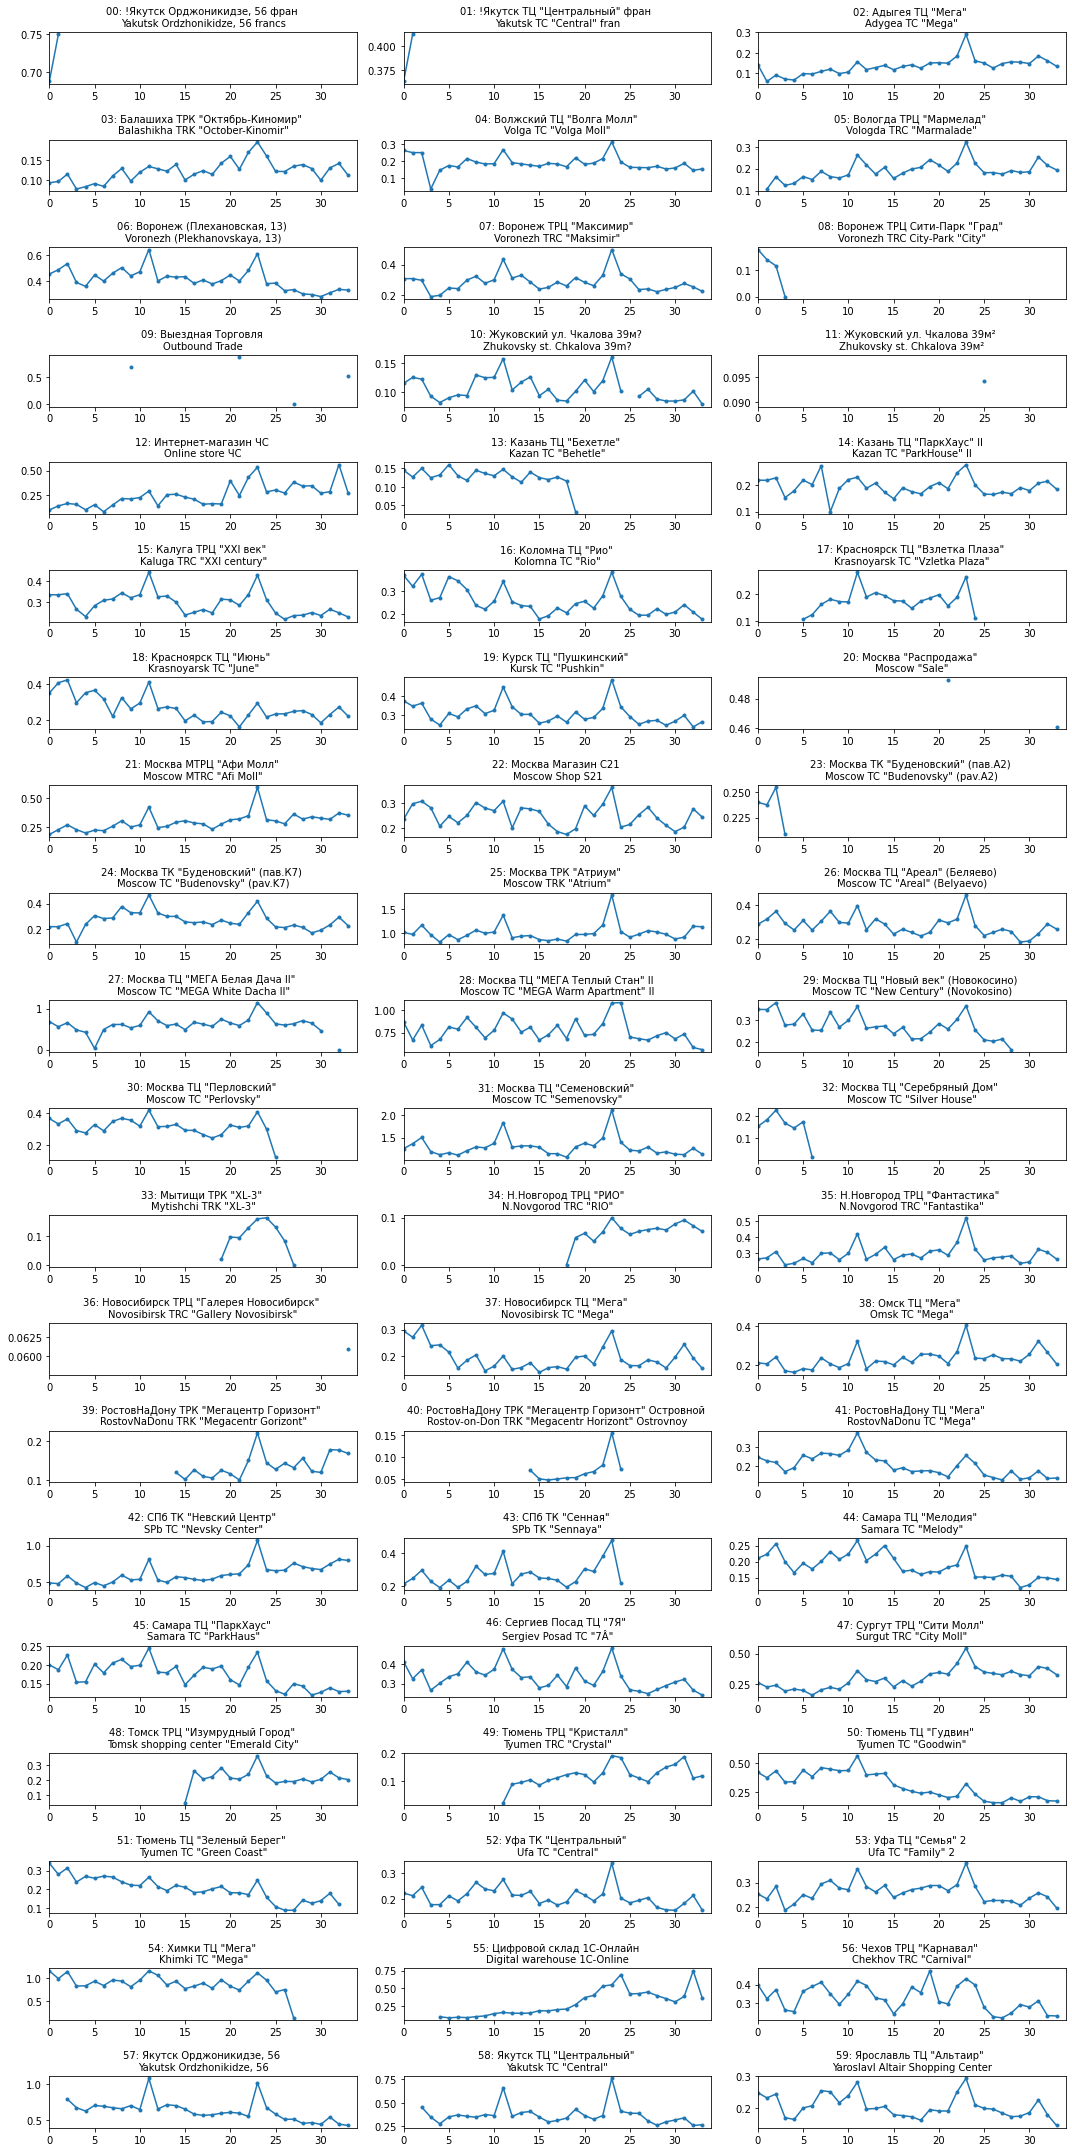

In [153]:
shops = pd.read_csv("data/shops_eng.csv", sep=';')
shops['shop_name_trans'] = shops['shop_name'] + " \n" + shops['shop_name_eng']
shopnamedict = { id : f"{id:02}: {name}" for name, id in zip(list(shops['shop_name_trans']), list(shops['shop_id']))}

ts = matrix.groupby(['date_block_num','shop_id'])['item_cnt_month'].mean()
ts = ts.reset_index()
ts['shop_name_trans'] = ts['shop_id'].map(shopnamedict)
tsp = ts.pivot(index='date_block_num',columns='shop_name_trans',values='item_cnt_month')

fig, axes = plt.subplots(20,3, figsize=(15,30))
for i, shop_name in enumerate(tsp.columns):
    idx = divmod(i,axes.shape[1])
    axes[idx[0]][idx[1]].plot(tsp.index,tsp.loc[:,shop_name], marker='.')
    axes[idx[0]][idx[1]].set_xlim(0,34)
    axes[idx[0]][idx[1]].set_title(shop_name, fontsize=10)
fig.tight_layout()

There are many points of interest here. Several shops appear to have been recorded under 2 different IDs and should be reassigned (0-57, 1-58 and 10-11), other shops are only open for a short time, others appear to be online only or occasional special categories rather than physical shops (e.g. 9 and 20). These could be removed or otherwise processed differently.

Finally, it can be noted that almost all shop names start with the name of the city in which the shop is located - this could be extracted and encoded as a feature.

In [11]:
# Correct shop labels
train.loc[train.shop_id == 0, "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
# Drop special categories
train = train.loc[(train.shop_id != 9) & (train.shop_id != 20), :]
# Remove data from short-lived shops
shops_to_remove = [8, 23, 32, 33, 40]
train = train.loc[~train["shop_id"].isin(shops_to_remove), :]

We can compare the shops in the test and train sets.

In [88]:
print(f"There are {len(set(test.shop_id) - set(train.shop_id))} shops in the test set that are not in the train set")
print(f"There are {len(set(train.shop_id) - set(test.shop_id))} shops in the train set that are not in the test set")

There are 0 shops in the test set that are not in the train set
There are 8 shops in the train set that are not in the test set


The train set only shops may improve test performance by providing more training data or decrease performance if their sales are too different to the test set shops. Performance with and without these shops could be compared.

## Sales by category
Sales can also be separated out according to category. As with the shop names, category names were translated to English.  
For comparison, the number of unique items per category is plotted on the same axis (in orange), to explore the possibility that this is informative.

In [ ]:
fig, axes = plt.subplots(28,3, figsize=(15,45))
for i, cat_name in enumerate(unique_items_cat_ts.columns):
    idx = divmod(i,axes.shape[1])
    axes[idx[0]][idx[1]].plot(unique_items_cat_ts.index,unique_items_cat_ts.loc[:,cat_name], marker='.')
    axes[idx[0]][idx[1]].set_xlim(0,34)
    axes[idx[0]][idx[1]].set_title(cat_name, fontsize=10)
fig.tight_layout()

Mean item_cnt_month (blue) and number of unique item_ids (orange) by category over time


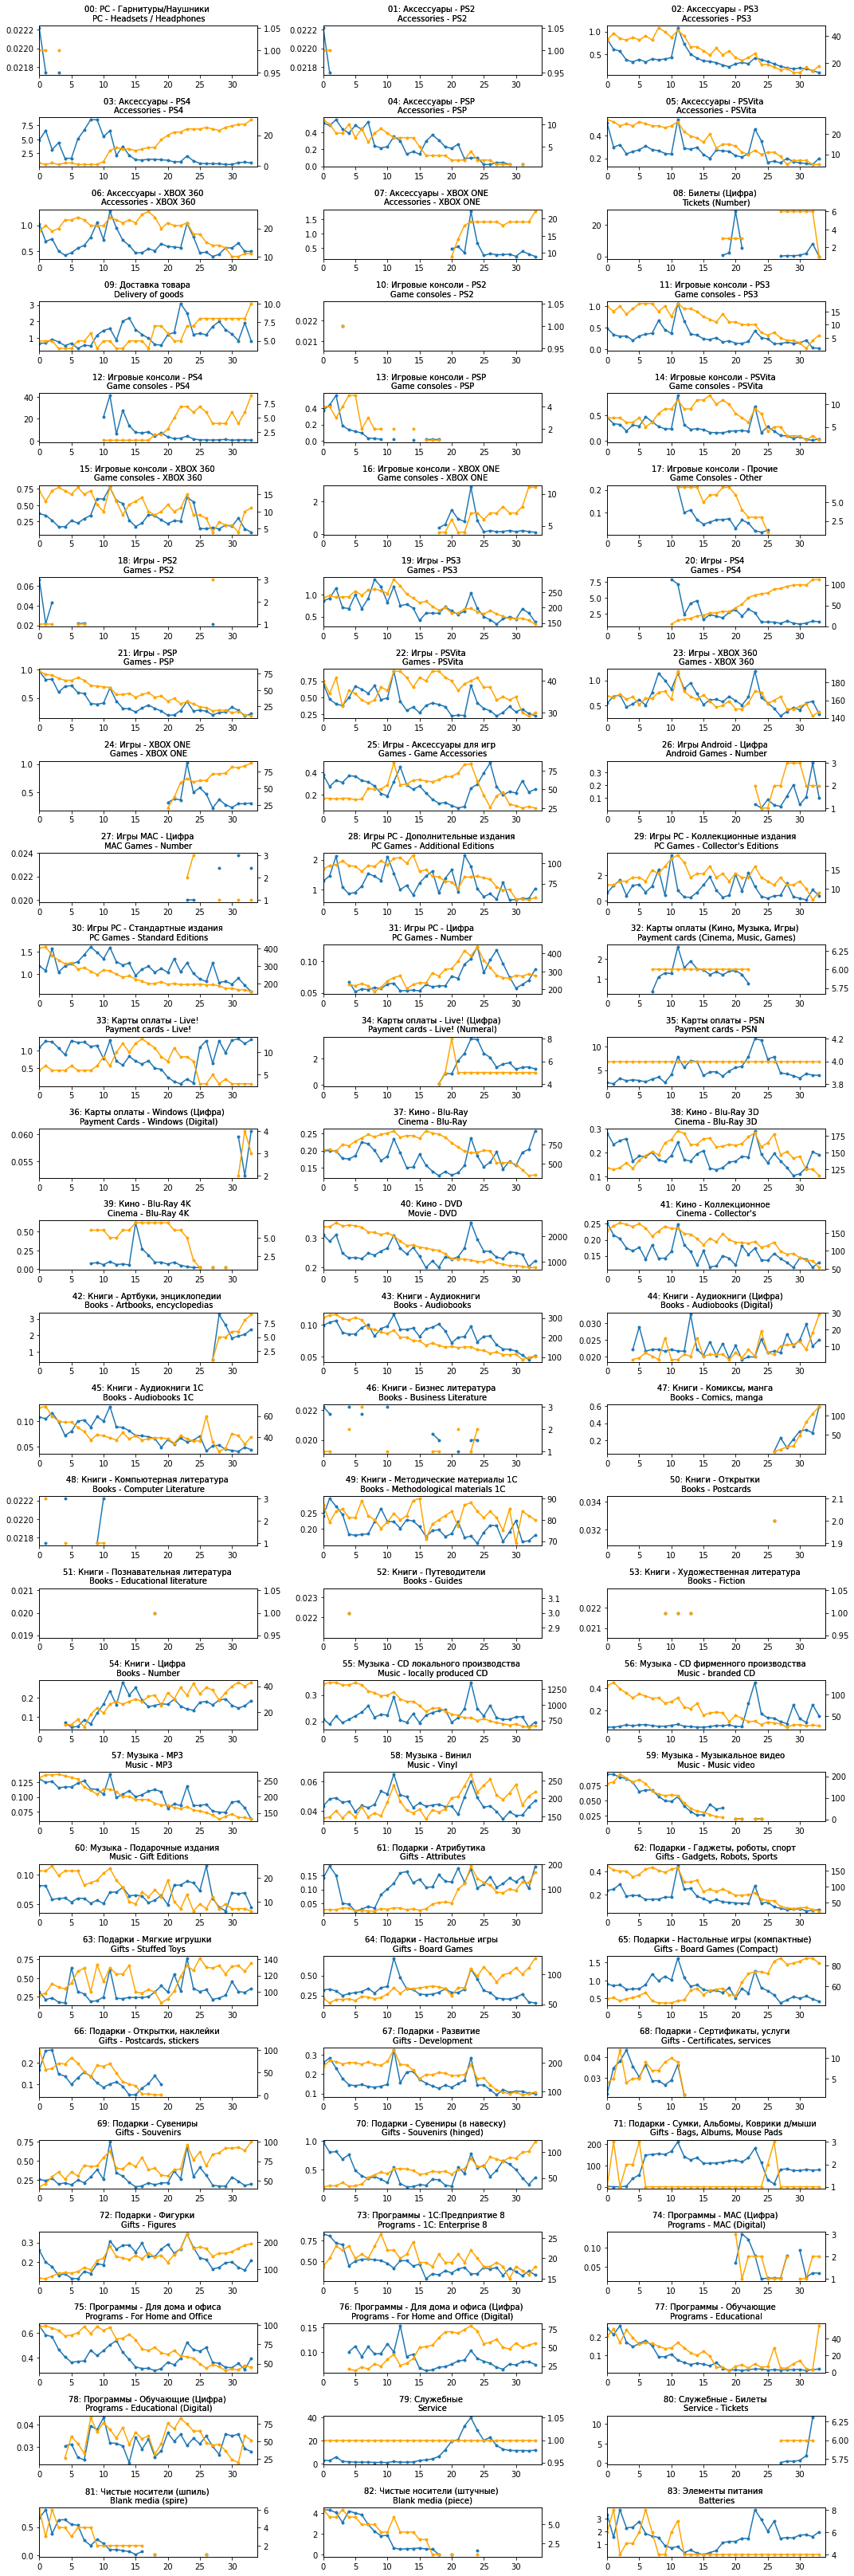

In [12]:
# Load the translated item names and make a dictionary of dual language names
item_categories = pd.read_csv("data/item_categories_eng.csv", sep=";")
item_categories["item_category_name_trans"] = (
    item_categories["item_category_name"]
    + " \n"
    + item_categories["item_category_name_eng"]
)
catnamedict = {
    id: f"{id:02}: {name}"
    for name, id in zip(
        list(item_categories["item_category_name_trans"]),
        list(item_categories["item_category_id"]),
    )
}

# Make a time series of unique items by category and reshape it as a pivot table
unique_id_cat = (
    train.groupby(["date_block_num", "item_category_id"])
    .item_id.nunique()
    .rename("unique_items_cat")
    .reset_index()
)
unique_id_cat["item_category_name_trans"] = unique_id_cat["item_category_id"].map(
    catnamedict
)
unique_items_cat_ts = unique_id_cat.pivot(
    index="date_block_num", columns="item_category_name_trans", values="unique_items_cat"
)

# Add the item categories to the feature and test matrices by merging
matrix = matrix.merge(items, on="item_id", how="left")
matrix = matrix.merge(item_categories, on="item_category_id", how="left")

# Create a time series of mean sales per item by category
ts = matrix.groupby(["date_block_num", "item_category_id"])["item_cnt_month"].mean()
ts = ts.reset_index()
ts["item_category_name_trans"] = ts["item_category_id"].map(catnamedict)
sales_cat = ts.pivot(
    index="date_block_num", columns="item_category_name_trans", values="item_cnt_month"
)

# Plot both series for all categories
print(
    "Mean item_cnt_month (blue) and number of unique item_ids (orange) by category over time"
)
fig, axes = plt.subplots(28, 3, figsize=(15, 45))
for i, cat_name in enumerate(sales_cat.columns):
    idx = divmod(i, axes.shape[1])
    axes[idx[0]][idx[1]].plot(sales_cat.index, sales_cat.loc[:, cat_name], marker=".")
    axes[idx[0]][idx[1]].set_xlim(0, 34)
    axes[idx[0]][idx[1]].set_title(cat_name, fontsize=10)
    ax2 = axes[idx[0]][idx[1]].twinx()
    ax2.plot(
        unique_items_cat_ts.index,
        unique_items_cat_ts.loc[:, cat_name],
        marker=".",
        color="orange",
    )
    ax2.set_xlim(0, 34)
    ax2.set_title(cat_name, fontsize=10)
fig.tight_layout()

There is a lot of information here : 

The number of unique items seems obviously related to sales, but inconsistently across categories - closely following mean sales for many categories, but unrelated or even negatively correlated for others. Still, this appears to be a clear data leak, although of uncertain value.

Some categories look like they could be split into supercategories and subcategories to create extra features, e.g. games and platform.

Some categories contain very few items or sales and could potentially be removed or combined with other categories.

Some categories become obsolete and could potentially be removed from the training data.

In [159]:
train_only_cats = set(matrix['item_category_id']) - set(test['item_category_id'])
print(f"There are {len(train_only_cats)} item categories in the train set that do not appear in the test set.")

There are 22 item categories in the train set that do not appear in the test set.


## Proportions of categories in train and test sets

83 categories is not so many so it is fairly easy to manually create more general supercategories like games, music etc. These have been saved in a csv table and can be used to clarify the makeup of items in the train and test sets.

In [371]:
item_categories = pd.read_csv('data_eng/categories_enhanced.csv')

In [381]:
matrix = matrix.merge(item_categories, how = 'left', on='item_category_id')
test = test.merge(item_categories, how = 'left', on='item_category_id')

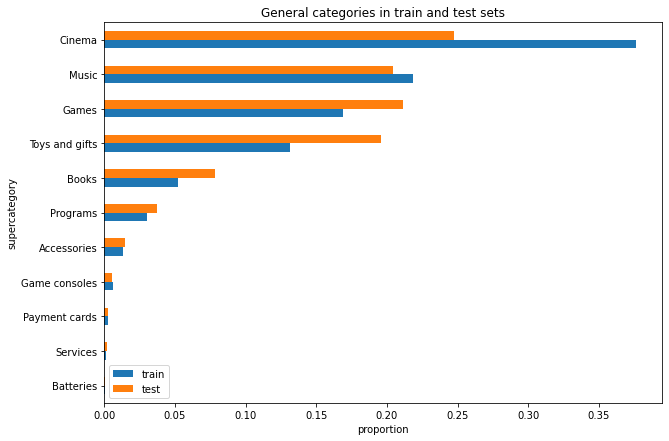

In [474]:
cat_proportions_train = matrix.groupby('supercategory').item_category_id.count()
cat_proportions_train = cat_proportions_train.rename('train')
cat_proportions_train = pd.DataFrame(cat_proportions_train)
cat_proportions_test = test.groupby('supercategory').item_category_id.count()
cat_proportions_test = cat_proportions_test.rename('test')
cat_proportions = cat_proportions_train.merge(cat_proportions_test, left_index=True, right_index=True)
cat_proportions = cat_proportions.sort_values('train', ascending=True)
cat_proportions = cat_proportions.transform(lambda x: x / x.sum())
ax = cat_proportions.plot.barh(figsize=(10,7))
_ = plt.title('General categories in train and test sets')
_ = plt.xlabel('proportion')

From this chart it is evident that the distribution of item types is different in the train and test sets. Compensating for this in some way may improve performance.

From this we can see that most of the items are cinema, music, games or toys, and categorization of these categories should be prioritized over others.  
As the data is from real historical sales, it should be possible to improve test performance by using information about real sales, e.g. increasing predictions for popular games, films and albums from November 2015.

### Relationship between price and sales
Create a table of item counts and prices

In [265]:
itemsales = matrix.groupby(["date_block_num", "item_id"]).agg(
    {"item_cnt_month": "sum", "item_revenue_month": "sum"}
)
itemsales["price"] = itemsales.item_revenue_month / itemsales.item_cnt_month
itemsales = itemsales.drop(columns=["item_cnt_month", "item_revenue_month"])
itemsales["item_cnt_month_mean"] = matrix.groupby(["date_block_num", "item_id"]).item_cnt_month.mean()
itemsales = itemsales.loc[slice(0, 33), slice(None), :]

Calculating prices in this way produces some negative and infinite values, these can be removed

In [266]:
itemsales = itemsales.drop(itemsales['price'][(itemsales['price']==np.inf) | (itemsales['price']<=0)].index)
itemsales = itemsales.drop(itemsales['item_cnt_month_mean'][(itemsales['item_cnt_month_mean']<=0)].index)

Plot sales counts over price

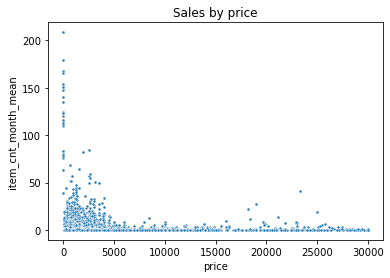

In [267]:
ax = sns.scatterplot(data=itemsales, x='price', y='item_cnt_month_mean', marker='.')
_ = ax.set_title('Sales by price')

The sales counts and prices are heavily skewed towards the lower end and are too numerous to see clearly on a plot.  

The trends are clearer if items are binned by price and mean values are calculated for bins.

Also plotted are trends for item prices relative to other items in the same category, and relative to the mean price of the same item over all months

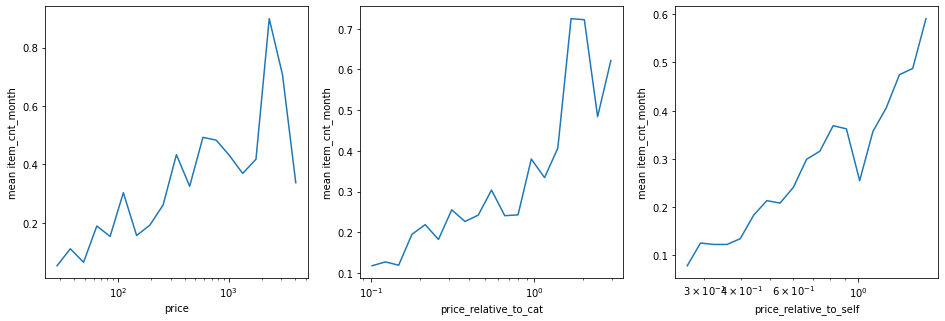

In [271]:
itemsales = itemsales.reset_index()
itemsales = itemsales.merge(items[['item_id','item_category_id']], how='left', on='item_id')
itemsales = itemsales.merge(item_categories, how='left', on='item_category_id')

itemsales['price_relative_to_cat'] = itemsales.groupby(['date_block_num','item_category_id'])['price'].transform(lambda x: x / x.mean())
itemsales['price_relative_to_self'] = itemsales.groupby(['item_id'])['price'].transform(lambda x: x / x.mean())

def calc_bin_means(feature_name):
    feature = itemsales[feature_name]
    mybins=np.logspace(np.log10(feature.quantile(0.01)), np.log10(feature.quantile(0.99)),20)
    bin_means, bin_edges, binnumber = stats.binned_statistic(feature, itemsales['item_cnt_month_mean'],
        statistic='mean', bins=mybins)
    bin_widths = np.diff(bin_edges)
    return (bin_means, bin_edges, binnumber)

feats = ['price', 'price_relative_to_cat', 'price_relative_to_self']
fig, axes = plt.subplots(1,3, figsize=(16,5))
for i, feature_name in enumerate(feats):
    bin_means, bin_edges, binnumber = calc_bin_means(feature_name)
    sns.lineplot(x=bin_edges[:-1], y=bin_means, ax=axes[i])
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('mean item_cnt_month')
    axes[i].set_xscale('log')

So it seems that there is a clear trend of decreasing sales with decreasing price, even within categories and for the same item at different times. As most of the items are media products such as films and games, maybe item prices are reduced as they become older and less 'hot'.  

Finally, the above plots were made excluding the highest and lowest 1% of items by price. When these are included, the plots look very diffeent and the central trend is not so obvious. This seems to indicate the presence of outliers which could distort predictions if not removed from the training data, but which could also increase prediction loss a lot if they are not predicted well for the test set. These 

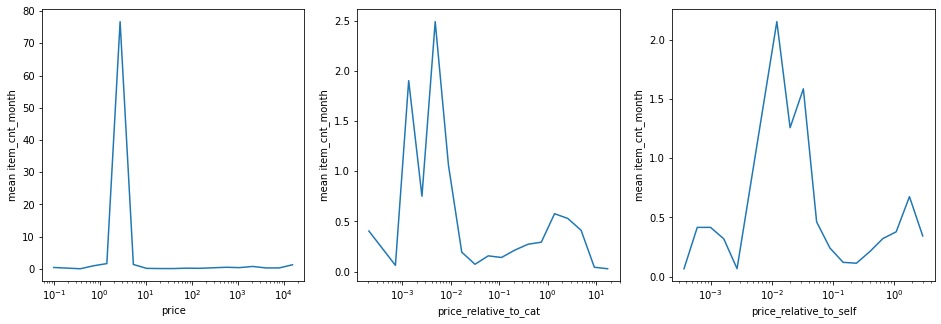

In [477]:
def calc_bin_means(feature_name):
    feature = itemsales[feature_name]
    mybins=np.logspace(np.log10(feature.min()), np.log10(feature.max()),20)
    bin_means, bin_edges, binnumber = stats.binned_statistic(feature, itemsales['item_cnt_month_mean'],
        statistic='mean', bins=mybins)
    bin_widths = np.diff(bin_edges)
    return (bin_means, bin_edges, binnumber)

feats = ['price', 'price_relative_to_cat', 'price_relative_to_self']
fig, axes = plt.subplots(1,3, figsize=(16,5))
for i, feature_name in enumerate(feats):
    bin_means, bin_edges, binnumber = calc_bin_means(feature_name)
    sns.lineplot(x=bin_edges[:-1], y=bin_means, ax=axes[i])
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('mean item_cnt_month')
    axes[i].set_xscale('log')